# Zillow Report
### By: Joann Balraj
#### December 13, 2021

 ![Image of Zillow Logo](https://theme.zdassets.com/theme_assets/512712/5675f10a90572d0f4140b0b39e72e4905bce34ee.jpg)

# Estimating Home Value

## Goals
- Predict values of single unit properties that the tax district access using the property data from those whose last transaction was during 2017
- Obtain States and Counties of properties
- Obtain tax rates for each country
- Provide distribution of tax rates for each county

## Hypotheses
- There is not a linear correlation between square footage of home and tax value.
- There is not a linear correlation between bedrooms and tax value.
- There is not a linear correlation between bathrooms and tax value.
- There is not a difference between tax value between Los Angeles and Orange County

#### Imports needed:

In [2]:
## python files that contain the functions to aquire and prep the data
import wrangle
import explore
import model
import pandas as pd
import numpy as np

# import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from math import sqrt
import math

# scikit learn
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE

#visulization settings
import graphviz
from sklearn.tree import export_graphviz
import matplotlib.style as style 
style.available
style.use('seaborn-talk') #sets the size of the charts
style.use('seaborn-colorblind') #sets color of charts

#warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = wrangle.clean_zillow(wrangle.get_zillow_data())

In [6]:
#Change fips to county names now that we know where they come from
df.rename(columns={"fips": "ca_county"}, inplace=True)

In [7]:
df['ca_county'] = df['ca_county'].map({6037: 'Los Angeles', 6059: 'Orange', 6111: 'Ventura'})

In [8]:
mvp = df.copy()
mvp.drop(['yearbuilt', 'county', 'zip_code', 'ca_county', 'latitude','longitude', 'taxamount', 'property_age', 'tax_rate'], axis=1, inplace=True)
mvp.head()

,bedrooms,bathrooms,square_feet,tax_value
parcelid,,,,
14297519,4,3.5,3100.0,1023282.0
17052889,2,1.0,1465.0,464000.0
14186244,3,2.0,1243.0,564778.0
12177905,4,3.0,2376.0,145143.0
10887214,3,3.0,1312.0,119407.0


# Explore
### Split:
- Data is split into train, validate, and test dataframes

In [9]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.train_validate_test_split(mvp,'tax_value', 123)

### Scale:
- will scale all numeric features to normalize the numeric range

In [10]:
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.Standard_Scaler(X_train, X_validate, X_test)

---

In [12]:
#create a handy dataframe for evaluating models or model and baseline value
#turn series into df
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [14]:
# predict the median for ytrain and yvalidate
baseline_median = y_train['tax_value'].median()
y_train['baseline_median'] = baseline_median
y_validate['baseline_median'] = baseline_median
#predict the mean for ytrain and yvalidate
baseline_mean = y_train['tax_value'].mean()
y_train['baseline_mean'] = baseline_mean
y_validate['baseline_mean'] = baseline_mean

In [15]:
# RMSE of pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.baseline_mean) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.baseline_mean) ** (1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# RMSE of pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.baseline_median) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.baseline_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  642444.76 
Validate/Out-of-Sample:  724108.89
RMSE using Median
Train/In-Sample:  655946.78 
Validate/Out-of-Sample:  736290.58


## Train and Validate
#### Linear Regression OLS

In [16]:
#make the thing
lm = LinearRegression(normalize=True)
#fit the thing
#only fit on training
lm.fit(X_train, y_train.tax_value)
#use the thing
y_train['pred_lm'] = lm.predict(X_train)

In [17]:
rmse_train_lm = mean_squared_error(y_train.tax_value, y_train.pred_lm)**(0.5)
# predict validate
y_validate['pred_lm'] = lm.predict(X_validate)
# evaluate: rmse
rmse_validate_lm = mean_squared_error(y_validate.tax_value, y_validate.pred_lm)**(0.5)

In [18]:
print(f'''
BASELINE:
              
RMSE using Median
Train/In-Sample: {round(rmse_train, 2)}
Validate/Out-of-Sample: {round(rmse_validate, 2)}
------------------------------------
RMSE for OLS using LinearRegression:
    
Training/In-Sample: {round(rmse_train_lm, 2)}
Validation/Out-of-Sample: {round(rmse_validate_lm, 2)}
''')


BASELINE:
              
RMSE using Median
Train/In-Sample: 655946.78
Validate/Out-of-Sample: 736290.58
------------------------------------
RMSE for OLS using LinearRegression:
    
Training/In-Sample: 501695.26
Validation/Out-of-Sample: 593433.03



## LassoLars

In [19]:
#make the thing
lars = LassoLars(alpha=1.0)
#fit the thing
lars.fit(X_train, y_train.tax_value)
#predict the thing: train
y_train['pred_lars'] = lars.predict(X_train)
# evaluate: rmse
rmse_train_lars = mean_squared_error(y_train.tax_value, y_train.pred_lars)**(0.5)
# predict the thing: validate
y_validate['pred_lars'] = lars.predict(X_validate)
# evaluate: rmse
rmse_validate_lars = mean_squared_error(y_validate.tax_value, y_validate.pred_lars)**(0.5)

In [20]:
print(f'''
BASELINE:
              
RMSE using Median
Train/In-Sample: {round(rmse_train, 2)}
Validate/Out-of-Sample: {round(rmse_validate, 2)}
------------------------------------
RMSE for OLS using LinearRegression:
    
Training/In-Sample: {round(rmse_train_lm, 2)}
Validation/Out-of-Sample: {round(rmse_validate_lm, 2)}
------------------------------------
RMSE for LassoLars:

Training/In-Sample: {round(rmse_train_lars, 2)}
Validation/Out-of-Sample: {round(rmse_validate_lars, 2)}
''')


BASELINE:
              
RMSE using Median
Train/In-Sample: 655946.78
Validate/Out-of-Sample: 736290.58
------------------------------------
RMSE for OLS using LinearRegression:
    
Training/In-Sample: 501695.26
Validation/Out-of-Sample: 593433.03
------------------------------------
RMSE for LassoLars:

Training/In-Sample: 501695.54
Validation/Out-of-Sample: 593427.35



## Tweedie Regressor

In [21]:
#make the thing
glm = TweedieRegressor(power=1, alpha=0)
#fit the thing 
glm.fit(X_train, y_train.tax_value)
#predict the thing: train
y_train['pred_glm'] = glm.predict(X_train)
# evaluate: rmse
rmse_train_glm = mean_squared_error(y_train.tax_value, y_train.pred_glm)**(0.5)
#predict the thing: validate
# predict validate
y_validate['pred_glm'] = glm.predict(X_validate)
# evaluate: rmse
rmse_validate_glm = mean_squared_error(y_validate.tax_value, y_validate.pred_glm)**(0.5)

In [22]:
print(f'''
BASELINE:
              
RMSE using Median
Train/In-Sample: {round(rmse_train, 2)}
Validate/Out-of-Sample: {round(rmse_validate, 2)}
------------------------------------
RMSE for OLS using LinearRegression:
    
Training/In-Sample: {round(rmse_train_lm, 2)}
Validation/Out-of-Sample: {round(rmse_validate_lm, 2)}
------------------------------------
RMSE for LassoLars:

Training/In-Sample: {round(rmse_train_lars, 2)}
Validation/Out-of-Sample: {round(rmse_validate_lars, 2)}
------------------------------------
RMSE for GLM using Tweedie, power=1 & alpha=0:

Training/In-Sample: {round(rmse_train_glm, 2)}
Validation/Out-of-Sample: {round(rmse_validate_glm, 2)}
''')


BASELINE:
              
RMSE using Median
Train/In-Sample: 655946.78
Validate/Out-of-Sample: 736290.58
------------------------------------
RMSE for OLS using LinearRegression:
    
Training/In-Sample: 501695.26
Validation/Out-of-Sample: 593433.03
------------------------------------
RMSE for LassoLars:

Training/In-Sample: 501695.54
Validation/Out-of-Sample: 593427.35
------------------------------------
RMSE for GLM using Tweedie, power=1 & alpha=0:

Training/In-Sample: 642444.76
Validation/Out-of-Sample: 724108.89



## Polynomial Regression

In [23]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)
# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)
# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [25]:
# create the model object
lm2 = LinearRegression(normalize=True)
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)
# predict train
y_train['pred_lm2'] = lm2.predict(X_train_degree2)
# evaluate: rmse
rmse_train_lm2 = mean_squared_error(y_train.tax_value, y_train.pred_lm2)**(0.5)
# predict validate
y_validate['pred_lm2'] = lm2.predict(X_validate_degree2)
# evaluate: rmse
rmse_validate_lm2 = mean_squared_error(y_validate.tax_value, y_validate.pred_lm2)**(0.5)

In [26]:
print(f'''
BASELINE:
              
RMSE using Median
Train/In-Sample: {round(rmse_train, 2)}
Validate/Out-of-Sample: {round(rmse_validate, 2)}
------------------------------------
RMSE for OLS using LinearRegression:
    
Training/In-Sample: {round(rmse_train_lm, 2)}
Validation/Out-of-Sample: {round(rmse_validate_lm, 2)}
------------------------------------
RMSE for LassoLars:

Training/In-Sample: {round(rmse_train_lars, 2)}
Validation/Out-of-Sample: {round(rmse_validate_lars, 2)}
------------------------------------
RMSE for GLM using Tweedie, power=1 & alpha=0:

Training/In-Sample: {round(rmse_train_glm, 2)}
Validation/Out-of-Sample: {round(rmse_validate_glm, 2)}
------------------------------------
RMSE for Polynomial Model, degrees=2:

Training/In-Sample: {round(rmse_train_lm2, 2)}
Validation/Out-of-Sample: {round(rmse_validate_lm2, 2)}

''')


BASELINE:
              
RMSE using Median
Train/In-Sample: 655946.78
Validate/Out-of-Sample: 736290.58
------------------------------------
RMSE for OLS using LinearRegression:
    
Training/In-Sample: 501695.26
Validation/Out-of-Sample: 593433.03
------------------------------------
RMSE for LassoLars:

Training/In-Sample: 501695.54
Validation/Out-of-Sample: 593427.35
------------------------------------
RMSE for GLM using Tweedie, power=1 & alpha=0:

Training/In-Sample: 642444.76
Validation/Out-of-Sample: 724108.89
------------------------------------
RMSE for Polynomial Model, degrees=2:

Training/In-Sample: 478871.47
Validation/Out-of-Sample: 531701.34




## Evaluate
### Plotting Actual vs. Predicted Values

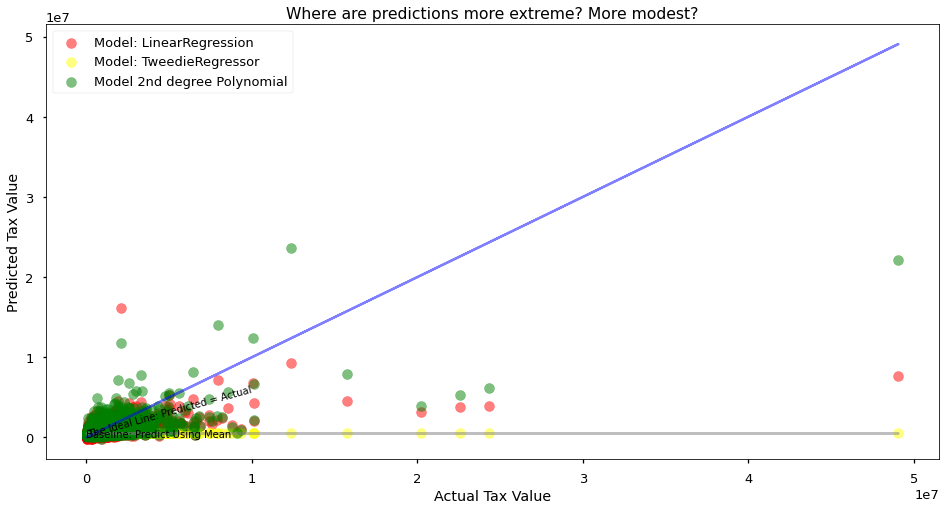

In [29]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.baseline_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.tax_value, y_validate.pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Where are predictions more extreme? More modest?");
#plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
#plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3));

In [30]:
metric_df = pd.DataFrame(data=[{
    'model': 'median_baseline', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.baseline_median)}])
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': rmse_validate_lm,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.pred_lm)}, ignore_index=True)
metric_df = metric_df.append({
    'model': 'Lasso alpha 1', 
    'RMSE_validate': rmse_validate_lars,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.pred_lars)}, ignore_index=True)
metric_df = metric_df.append({
    'model': 'GLS (Poisson)', 
    'RMSE_validate': rmse_validate_glm,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.pred_glm)}, ignore_index=True)
metric_df = metric_df.append({
    'model': 'Quadratic Model', 
    'RMSE_validate': rmse_validate_lm2,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.pred_lm2)}, ignore_index=True)
metric_df

,model,RMSE_validate,r^2_validate
0,median_baseline,736290.584878,0.000000
1,OLS Regressor,593433.025501,0.328366
2,Lasso alpha 1,593427.350637,0.328379
3,GLS (Poisson),724108.894367,0.000000
4,Quadratic Model,531701.343262,0.460832


### Test

In [33]:
y_test = pd.DataFrame(y_test)
#predict on test
y_test['pred_lm2'] = lm2.predict(X_test_degree2)
# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.pred_lm2)**(0.5)

print(f"""
RMSE for Polynomial Regressor, degrees=2:
    
Test/Out-of-Sample Performance: {rmse_test}
""")


RMSE for Polynomial Regressor, degrees=2:
    
Test/Out-of-Sample Performance: 433741.44914605323



In [34]:
train

,bedrooms,bathrooms,square_feet,tax_value
parcelid,,,,
17228134,3,2.0,1888.0,246735.0
11357458,3,2.0,1484.0,149689.0
17153382,2,2.0,1937.0,540544.0
14682419,3,3.0,1526.0,630000.0
10914366,2,2.0,1114.0,460475.0
...,...,...,...,...
11644337,3,4.0,4422.0,2101164.0
13926156,3,2.0,2318.0,258508.0
14306263,3,2.0,1538.0,718578.0


## Acquire More Data for Model
- same dataset from the beginning, but this time I will keep more variables

In [36]:
df = wrangle.clean_zillow(wrangle.get_zillow_data())

In [37]:
#handle outliers
columns = ['bedrooms', 'bathrooms','square_feet', 'tax_value']
for x in columns:
    
    Q1 = df[x].quantile(0.25)
    Q3 = df[x].quantile(0.75)
    IQR = (Q3 - Q1) * 1.5
    upper = Q3 + (1.5 * IQR)
    lower = Q1 - (1.5 * IQR)
    df = df[df[x] < (upper)]
    
    print('column:', x,'\nIQR:', IQR, '\nUpper bound:', upper, '\nLower bound:', lower, '\n')

column: bedrooms 
IQR: 3.0 
Upper bound: 8.5 
Lower bound: -2.5 

column: bathrooms 
IQR: 1.5 
Upper bound: 5.25 
Lower bound: -0.25 

column: square_feet 
IQR: 1350.0 
Upper bound: 4102.0 
Lower bound: -848.0 

column: tax_value 
IQR: 514925.25 
Upper bound: 1318084.875 
Lower bound: -569974.375 



In [38]:
#features that will be dropped for this iteration
df.drop(['county', 'zip_code', 'latitude', 'longitude', 'taxamount'], axis=1, inplace=True)
#change fips to object so it doesnt get scaled later
df['fips'] = df['fips'].astype(object)

# Explore
#### Split

In [39]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.train_validate_test_split(df,'tax_value', 123)

#### Scale

In [40]:
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.Standard_Scaler(X_train, X_validate, X_test)

## Univariate takeways:
   I used my explore_univariate function from my explore.py module (visuals shown in workbook)
- Los Angeles properties dominated the dataset with ~ 65% of the properties coming from this county
- Mean property age is ~ 53 years

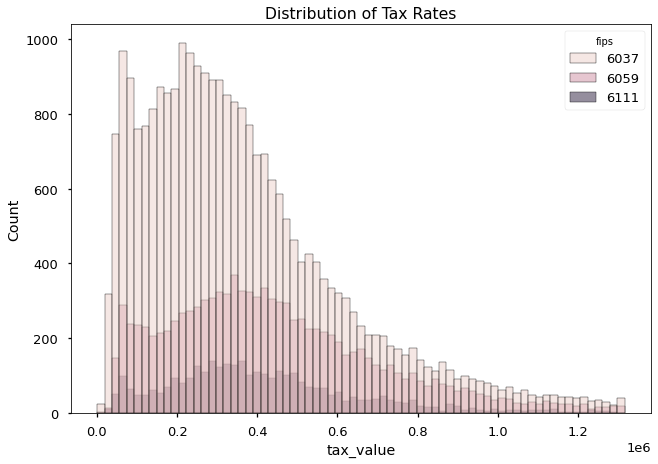

In [41]:
sns.histplot(data=train, x="tax_value", hue = 'fips')
plt.title('Distribution of Tax Rates');

## LA has the highest tax value followed by OC, then VC

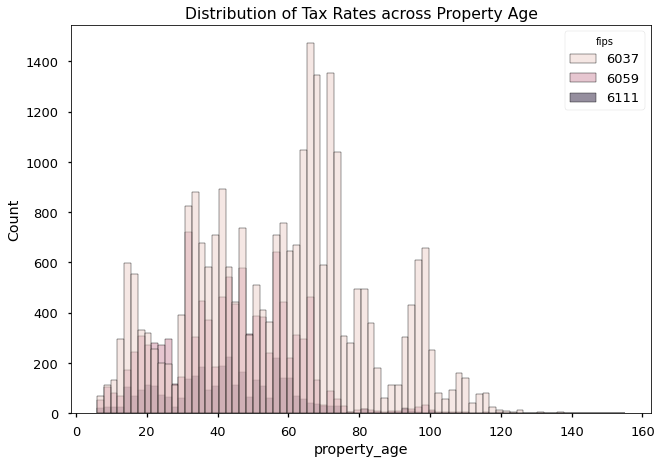

In [42]:
sns.histplot(data=train, x="property_age", hue = 'fips')
plt.title('Distribution of Tax Rates across Property Age');

### Majority of homes older than 60 years seem to be concentrated in LA.

### According to ttest, there is a difference between the mean tax values of LA and OC
## Feature Engineering

### Feature Engineering Takeaways:
- top 3 features are bedrooms, bathrooms, and square feet which we explored earlier
- next features to explore are yearbuilt and property age

In [44]:
#Create a Handy DataFrame for Evaluating Your Models or Model and Baseline Value.
#turn series into df
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_train.head()

,tax_value
parcelid,
12815320,581233.0
11490249,575755.0
11695472,137258.0
12960692,437512.0
13057060,646000.0


### Baseline

In [45]:
# predict the median for ytrain and yvalidate
baseline_median = y_train['tax_value'].median()
y_train['baseline_median'] = baseline_median
y_validate['baseline_median'] = baseline_median
#predict the mean for ytrain and yvalidate
baseline_mean = y_train['tax_value'].mean()
y_train['baseline_mean'] = baseline_mean
y_validate['baseline_mean'] = baseline_mean

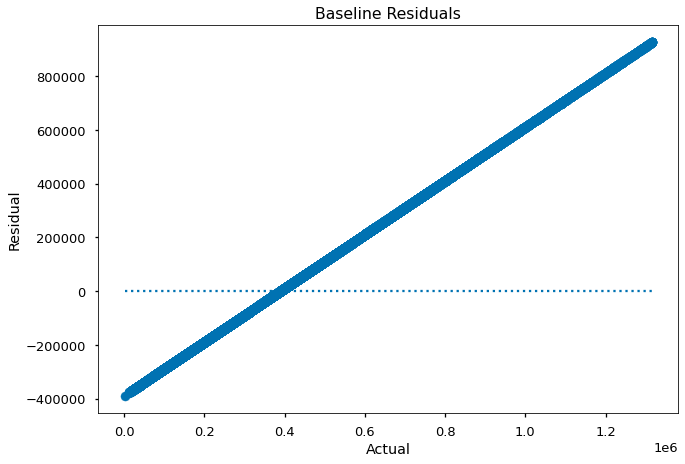

In [46]:
model.plot_residuals(y_train.tax_value, y_train.baseline_mean)

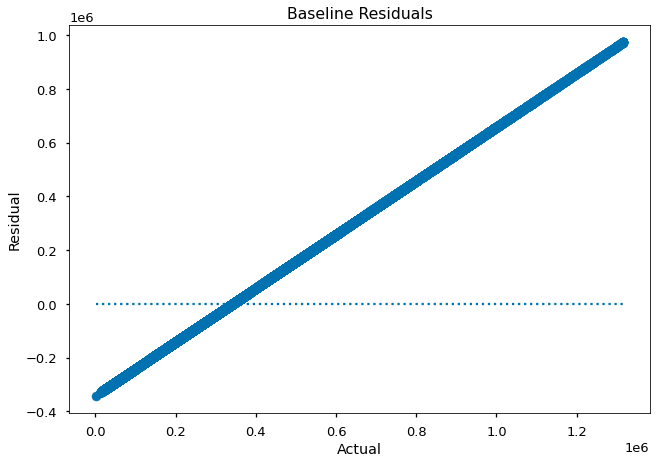

In [47]:
model.plot_residuals(y_train.tax_value, y_train.baseline_median)

In [48]:
#Evaluate the baseline model using the mean
model.baseline_mean_errors(y_train.tax_value)

{'sse': 2669874206269131.0,
 'mse': 65640807549.51888,
 'rmse': 256204.62046871614}

In [49]:
#Evaluate the baseline model using the median
model.baseline_median_errors(y_train.tax_value)

{'sse': 2762248820911300.5,
 'mse': 67911904924.79964,
 'rmse': 260599.1268688359}

In [50]:
# RMSE of pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.baseline_mean) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.baseline_mean) ** (1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  256204.62 
Validate/Out-of-Sample:  256297.67


In [51]:
#RMSE of pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.baseline_median) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.baseline_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Median
Train/In-Sample:  260599.13 
Validate/Out-of-Sample:  260371.98


In [52]:
#going to use mean

## Train and Validate
### Linear Regression OLS

In [53]:
#make the thing
lm = LinearRegression(normalize=True)
#fit the thing
#only fit on training
lm.fit(X_train, y_train.tax_value)
#use the thing
y_train['pred_lm'] = lm.predict(X_train)
y_train.head()

rmse_train_lm = mean_squared_error(y_train.tax_value, y_train.pred_lm)**(0.5)
# predict validate
y_validate['pred_lm'] = lm.predict(X_validate)
# evaluate: rmse
rmse_validate_lm = mean_squared_error(y_validate.tax_value, y_validate.pred_lm)**(0.5)

### Lasso Lars

In [54]:
#make the thing
lars = LassoLars(alpha=1.0)
#fit the thing
lars.fit(X_train, y_train.tax_value)
#predict the thing: train
y_train['pred_lars'] = lars.predict(X_train)
# evaluate: rmse
rmse_train_lars = mean_squared_error(y_train.tax_value, y_train.pred_lars)**(0.5)
# predict the thing: validate
y_validate['pred_lars'] = lars.predict(X_validate)
# evaluate: rmse
rmse_validate_lars = mean_squared_error(y_validate.tax_value, y_validate.pred_lars)**(0.5)

### Tweedie Regressor

In [55]:
#make the thing
glm = TweedieRegressor(power=1, alpha=0)
#fit the thing 
glm.fit(X_train, y_train.tax_value)
#predict the thing: train
y_train['pred_glm'] = glm.predict(X_train)
# evaluate: rmse
rmse_train_glm = mean_squared_error(y_train.tax_value, y_train.pred_glm)**(0.5)
#predict the thing: validate
# predict validate
y_validate['pred_glm'] = glm.predict(X_validate)
# evaluate: rmse
rmse_validate_glm = mean_squared_error(y_validate.tax_value, y_validate.pred_glm)**(0.5)

### Polynomial Regression

In [56]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)
# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)
# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)
# create the model object
lm2 = LinearRegression(normalize=True)
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)
# predict train
y_train['pred_lm2'] = lm2.predict(X_train_degree2)
# evaluate: rmse
rmse_train_lm2 = mean_squared_error(y_train.tax_value, y_train.pred_lm2)**(0.5)
# predict validate
y_validate['pred_lm2'] = lm2.predict(X_validate_degree2)
# evaluate: rmse
rmse_validate_lm2 = mean_squared_error(y_validate.tax_value, y_validate.pred_lm2)**(0.5)

In [57]:
print(f'''
BASELINE:
              
RMSE using Median
Train/In-Sample: {round(rmse_train, 2)}
Validate/Out-of-Sample: {round(rmse_validate, 2)}
------------------------------------
RMSE for OLS using LinearRegression:
    
Training/In-Sample: {round(rmse_train_lm, 2)}
Validation/Out-of-Sample: {round(rmse_validate_lm, 2)}
------------------------------------
RMSE for LassoLars:

Training/In-Sample: {round(rmse_train_lars, 2)}
Validation/Out-of-Sample: {round(rmse_validate_lars, 2)}
------------------------------------
RMSE for GLM using Tweedie, power=1 & alpha=0:

Training/In-Sample: {round(rmse_train_glm, 2)}
Validation/Out-of-Sample: {round(rmse_validate_glm, 2)}
------------------------------------
RMSE for Polynomial Model, degrees=2:

Training/In-Sample: {round(rmse_train_lm2, 2)}
Validation/Out-of-Sample: {round(rmse_validate_lm2, 2)}

''')


BASELINE:
              
RMSE using Median
Train/In-Sample: 260599.13
Validate/Out-of-Sample: 260371.98
------------------------------------
RMSE for OLS using LinearRegression:
    
Training/In-Sample: 213578.33
Validation/Out-of-Sample: 213554.13
------------------------------------
RMSE for LassoLars:

Training/In-Sample: 213567.0
Validation/Out-of-Sample: 213555.93
------------------------------------
RMSE for GLM using Tweedie, power=1 & alpha=0:

Training/In-Sample: 256204.62
Validation/Out-of-Sample: 256297.67
------------------------------------
RMSE for Polynomial Model, degrees=2:

Training/In-Sample: 201985.91
Validation/Out-of-Sample: 203419.5




## Evaluate

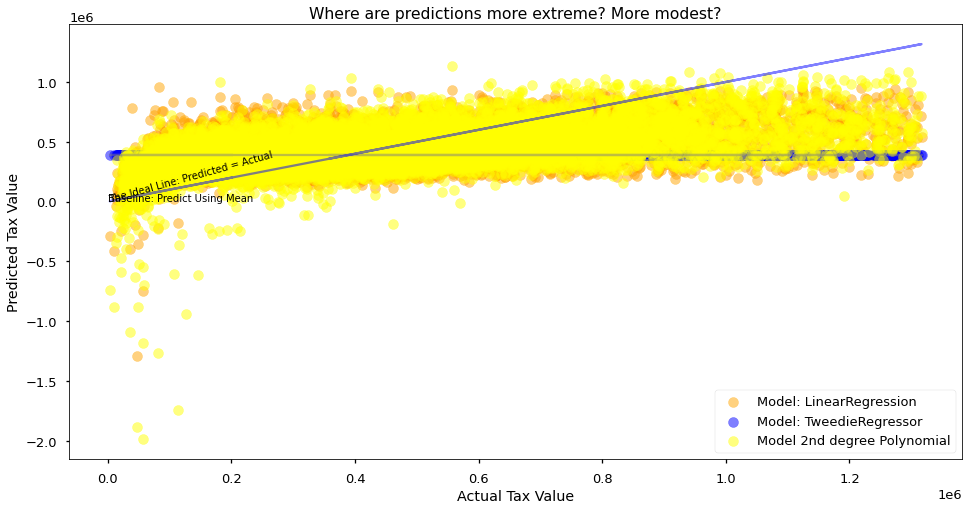

In [58]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.baseline_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.tax_value, y_validate.pred_lm, 
            alpha=.5, color="orange", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.pred_glm, 
            alpha=.5, color="blue", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.pred_lm2, 
            alpha=.5, color="yellow", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

In [59]:
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.baseline_mean)}])
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': rmse_validate_lm,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.pred_lm)}, ignore_index=True)
metric_df = metric_df.append({
    'model': 'Lasso alpha 1', 
    'RMSE_validate': rmse_validate_lars,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.pred_lars)}, ignore_index=True)
metric_df = metric_df.append({
    'model': 'GLS (Poisson)', 
    'RMSE_validate': rmse_validate_glm,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.pred_glm)}, ignore_index=True)
metric_df = metric_df.append({
    'model': 'Quadratic Model', 
    'RMSE_validate': rmse_validate_lm2,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.pred_lm2)}, ignore_index=True)

In [60]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,260371.981338,0.000000
1,OLS Regressor,213554.133920,0.305706
2,Lasso alpha 1,213555.925117,0.305692
3,GLS (Poisson),256297.668893,0.000000
4,Quadratic Model,203419.504889,0.370039


## TEST OUR BEST
- The best model was the polynomial model again with r^2 of 0.37, so we will test on this model

In [62]:
y_test = pd.DataFrame(y_test)

#predict on test
y_test['pred_lm2'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.pred_lm2)**(0.5)

print(f"""
RMSE for Polynomial Regressor, degrees = 2:
    
Test/Out-of-Sample Performance: {rmse_test}
""")


RMSE for Polynomial Regressor, degrees = 2:
    
Test/Out-of-Sample Performance: 200650.39789719708



## Final Recommendation and Takeaways:
### Takeaways from Evaluating Test Data on RMSE for Polynomial Model, degrees = 2
- Recommend using the Polynomial Regression Model (degree of 2) to predict home values based on bathroom count, age of home, square footage and zip code.

- Note: Scatterplot visualization demonstrates that our model tends to under-value homes that exceed the median tax value of about 408K

### Given more Time and Resources, I would:
- Fine tune feature engineering, perhaps combining some features, to increase accuracy.
- Since there was little difference in the RMSE for mean and median, I would re-run models using median as baseline, whereas median was 399k which may be more representative
- Reconfigure many of my explorations and modeling code into as functions, to clean up notebook and increase reproducibility of results